### Deskripsi Singkat Dataset:

tulis deskripsi singkat dataset yang Anda gunakan

---

### Dataset yang diambil dari repositori:

COVID Face Mask Detection Dataset – sumber : https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset

### Hasil kerja

In [128]:
import argparse
import cv2
import math, time, random, datetime
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import imutils
import warnings

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential


from mtcnn.mtcnn import MTCNN

warnings.filterwarnings('ignore')

Path untuk folder data

In [129]:
# TRAIN_PATH  = './kaggle/Train' #Mengandung 90% dari dataset
# TEST_PATH  = './kaggle/Test' # Mengandung 10% dari dataset

IMAGE_PATH = './dataset'

IMG_SIZE = 224

In [130]:
print("Classes")
print(os.listdir(IMAGE_PATH))

Classes
['incorrect_mask', 'without_mask', 'with_mask']


In [131]:
labels = {}
for index, c  in enumerate(os.listdir(IMAGE_PATH)):
    labels[c] = index;
labels

{'incorrect_mask': 0, 'without_mask': 1, 'with_mask': 2}

### PREPROCESSING

Memberi Label pada gambar serta membagi dataset menjadi training dan validation.
PREPROCESSING: 
1. LABELLING DATA
2. MEMISAHKAN DATA (berdasarkan random seed: 123)
3. RESIZE IMAGE (menggunakan billinear interpolation)
4. COLOR MODE : GRAYSCALE

In [132]:
print("TRAINING + VALIDATION")

seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
  IMAGE_PATH,
  validation_split=0.3,
  subset="training",
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)

target_ds = tf.keras.utils.image_dataset_from_directory(
  IMAGE_PATH,
  validation_split=0.3,
  subset="validation",
  seed=seed,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=32
  # color_mode="grayscale"
)
# print("TESTING")
# test_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGE_PATH,
#   seed=seed,
#   image_size=(IMG_SIZE, IMG_SIZE),
#   batch_size=32
#   # color_mode="grayscale"
# )

TRAINING + VALIDATION
Found 2079 files belonging to 3 classes.
Using 1456 files for training.
Found 2079 files belonging to 3 classes.
Using 623 files for validation.


BUAT TEST SPLIT

In [133]:
val_ds, test_ds = tf.keras.utils.split_dataset(dataset=target_ds, left_size=0.75)

Menyetelkan buffered prefetching untuk mengurangi pengambilan gambar dari disk.

Menunjukkan 9 data pertama dari dataset Training.

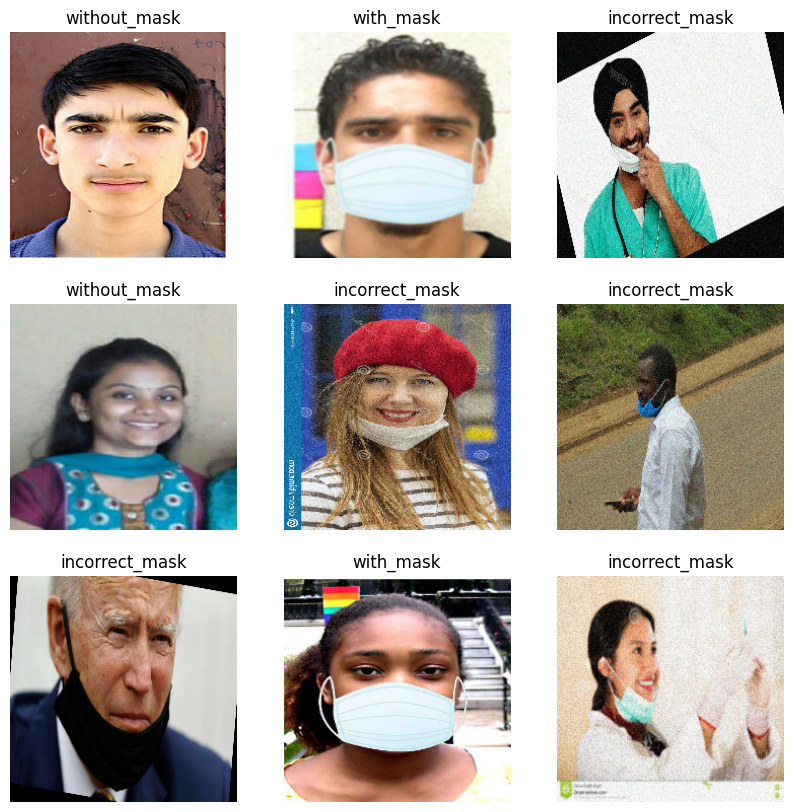

In [134]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [135]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Rescale pixel dari 0-255 menjadi [-1,1].

In [136]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Membuat Model menggunakan MobileNetV2 sebagai Base model.

In [137]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Include false agar dapat menggantikan top layer dari model dengan layer khusus kita nanti
                                               weights='imagenet')

Jika telah inisialisasi model, maka memasukin training model.

Sebelum model dilatih, base_model trainable dimatikan dulu. Kita ingin mematikan layer-layer bawah dari model agar tidak menggantikan bobot yang membuatnya mengenal objek.

Layer convolution pada lapisan pertama base_model akan berfungsi sebagai feature extractor.

In [138]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Feature Extraction dalam MobileNetV2 akan mengubah data pixel kita menjadi 7x7x1280 (karena filter yang telah digunakan pada convolution layernya).

In [139]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
feature_batch.numpy()[1]

(32, 7, 7, 1280)


array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5397961 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.24659346, 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.6957351 , 1.9161375 , 0.        , ..., 0.        ,
         1.1806425 , 0.        ],
        [1.4061074 , 0.        , 0.        , ..., 0.        ,
         0.17160067, 0.38034752],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

Kita akan menggunakan Global Average Pooling 2D layer untuk mengubah vector yang didapati dari base_model menjadi 1280 vector.

Setelah mendapatkan vector tersebut membuat klasifikasi dilakukan menggunakan Dense Layer.

In [140]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Flattening
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dimasukkan Dropout untuk menghindari overfitting
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [141]:
# CARA SEBELUMNYA
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(1)
# stacked_layers = [global_average_layer, prediction_layer]
# model = tf.keras.Sequential([base_model] + stacked_layers)

Menetapkan base_learning_rate dan membuat membuat model.

In [142]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate), loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

Rangkaian Model Terkahir:

In [143]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

### Melatih dan membuat evaluasi
Jika tanpa training hasil yang diberikan adalah:

In [144]:
validation_steps = 15
initial_epochs = 10

loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

15/15 [==============================] - 2s 49ms/step - loss: 1.3396 - accuracy: 0.2762


Dapa dilihat, model hanya 0.6077 akurat dalam mendeteksi wajah bermasker. Hal ini tidak bagus karena, jika model menebak maka hasilnya 0.5. Jadi meskipun memiliki bobot dari ImageNet dan architecure MobileNetV2 (transfer learning), model hanya  bisa menentukan wajah bermasker sedikit lebih baik dari penebakan.

Melatih model (layer teratas)

In [145]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
46/46 [==============================] - 6s 71ms/step - loss: 1.0864 - accuracy: 0.4684 - val_loss: 0.7673 - val_accuracy: 0.7109
Epoch 2/10
46/46 [==============================] - 4s 70ms/step - loss: 0.6915 - accuracy: 0.7294 - val_loss: 0.5089 - val_accuracy: 0.8587
Epoch 3/10
46/46 [==============================] - 3s 69ms/step - loss: 0.4763 - accuracy: 0.8530 - val_loss: 0.3486 - val_accuracy: 0.9229
Epoch 4/10
46/46 [==============================] - 3s 68ms/step - loss: 0.3573 - accuracy: 0.8970 - val_loss: 0.2645 - val_accuracy: 0.9400
Epoch 5/10
46/46 [==============================] - 3s 68ms/step - loss: 0.2607 - accuracy: 0.9348 - val_loss: 0.2076 - val_accuracy: 0.9486
Epoch 6/10
46/46 [==============================] - 3s 68ms/step - loss: 0.2098 - accuracy: 0.9416 - val_loss: 0.1714 - val_accuracy: 0.9593
Epoch 7/10
46/46 [==============================] - 3s 69ms/step - loss: 0.1785 - accuracy: 0.9526 - val_loss: 0.1501 - val_accuracy: 0.9679
Epoch 8/10
46

History dari Training dan Fitting

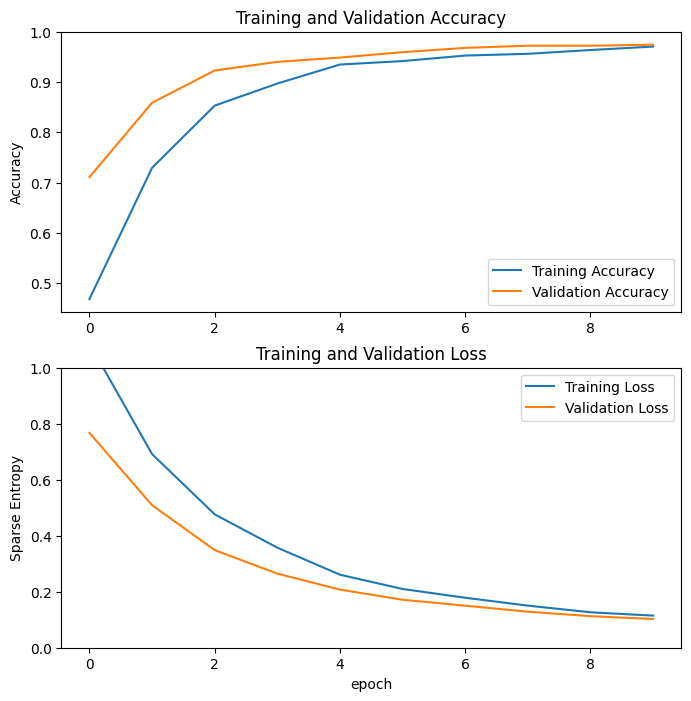

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluasi dengan Testing

In [147]:
testing_steps = 4
loss1,accuracy1 = model.evaluate(test_ds, steps = testing_steps)

4/4 [==============================] - 0s 47ms/step - loss: 0.0971 - accuracy: 0.9844


In [148]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

Fine-tuning model saat epoch = 50

In [149]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [150]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [126]:
# Kita turunin base_learning supaya tidak terlalu mengbuhah seluruh bobot (dengan trainable paramter yang lebih besar) dengan pesat sehingga overfitting  
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), 
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [151]:
model.evaluate(test_ds, steps=4)

4/4 [==============================] - 0s 54ms/step - loss: 0.0971 - accuracy: 0.9844


[0.09709572792053223, 0.984375]

In [152]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [153]:
len(model.trainable_variables)

56

In [154]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch= initial_epochs, validation_data = val_ds)

Epoch 11/20
46/46 [==============================] - 4s 76ms/step - loss: 0.0971 - accuracy: 0.9746 - val_loss: 0.0913 - val_accuracy: 0.9764
Epoch 12/20
46/46 [==============================] - 4s 69ms/step - loss: 0.0941 - accuracy: 0.9773 - val_loss: 0.0847 - val_accuracy: 0.9764
Epoch 13/20
46/46 [==============================] - 3s 69ms/step - loss: 0.0883 - accuracy: 0.9753 - val_loss: 0.0794 - val_accuracy: 0.9764
Epoch 14/20
46/46 [==============================] - 3s 67ms/step - loss: 0.0761 - accuracy: 0.9794 - val_loss: 0.0733 - val_accuracy: 0.9786
Epoch 15/20
46/46 [==============================] - 3s 67ms/step - loss: 0.0694 - accuracy: 0.9856 - val_loss: 0.0698 - val_accuracy: 0.9786
Epoch 16/20
46/46 [==============================] - 3s 67ms/step - loss: 0.0677 - accuracy: 0.9849 - val_loss: 0.0644 - val_accuracy: 0.9807
Epoch 17/20
46/46 [==============================] - 3s 68ms/step - loss: 0.0606 - accuracy: 0.9870 - val_loss: 0.0616 - val_accuracy: 0.9807
Epoch 

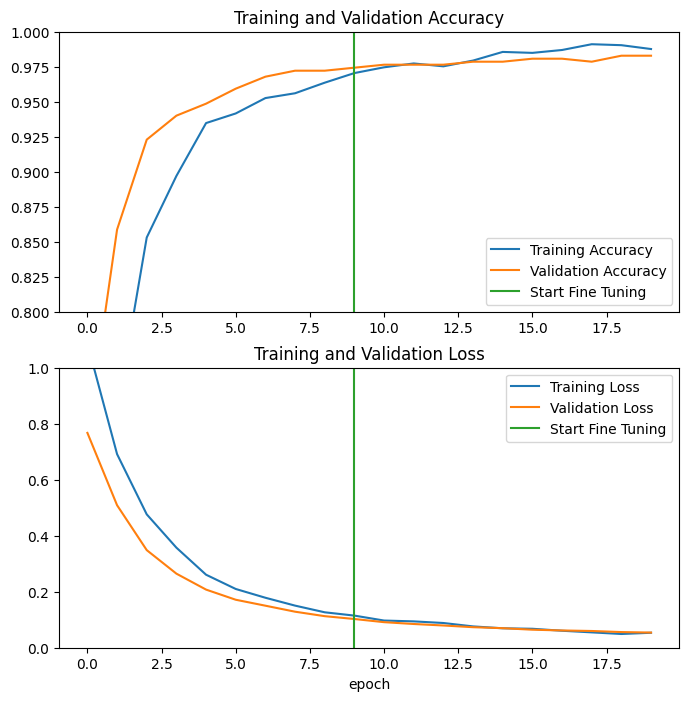

In [155]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Final Evaluation

In [156]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 161ms/step - loss: 0.0454 - accuracy: 0.9936
Test accuracy : 0.9935897588729858


In [172]:
iterator = test_ds.as_numpy_iterator()

In [188]:
image_batch, label_batch = iterator.next()
predictions = model.predict_on_batch(image_batch)

In [193]:
predictions

array([[1.02372495e-02, 2.16285858e-04, 9.89546478e-01],
       [5.79738431e-02, 1.35841900e-02, 9.28442001e-01],
       [9.01110590e-01, 4.97696288e-02, 4.91197631e-02],
       [9.59081113e-01, 3.51844802e-02, 5.73434820e-03],
       [7.15640839e-04, 9.99179542e-01, 1.04845611e-04],
       [1.31884147e-03, 9.98575091e-01, 1.06061205e-04],
       [2.35162937e-04, 9.99703705e-01, 6.11937649e-05],
       [9.81376350e-01, 5.62565448e-03, 1.29979933e-02],
       [4.78201509e-05, 9.99860168e-01, 9.20722523e-05],
       [3.39731248e-03, 9.96549249e-01, 5.34061255e-05],
       [2.83407923e-02, 9.28463757e-01, 4.31954674e-02],
       [1.32751558e-02, 9.85719502e-01, 1.00533792e-03],
       [8.54042417e-04, 9.96870220e-01, 2.27566482e-03],
       [9.37963903e-01, 4.24690507e-02, 1.95669532e-02],
       [7.58639097e-01, 8.47169757e-03, 2.32889235e-01],
       [1.36597286e-04, 9.99823034e-01, 4.03569102e-05],
       [9.46984649e-01, 5.24711385e-02, 5.44234761e-04],
       [2.69942526e-02, 9.55570

Labels:
 [2 2 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 2 0 1 0 0 0 1 0]


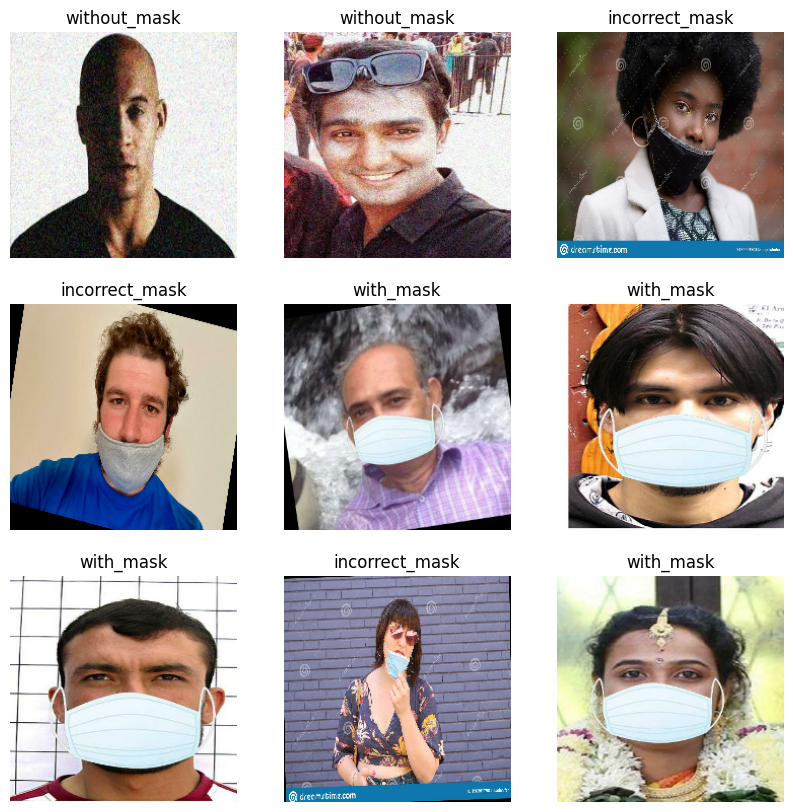

In [194]:
# Apply a sigmoid since our model returns logits
print('Labels:\n', label_batch)



plt.figure(figsize=(10, 10))
for i in range(9):
  p = predictions[i].argmax()
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[p])
  plt.axis("off")

# Membuat Classifier mengenal beberapa object dalam sebuah gambar

Untuk mengetest model MobileNetV2 dalam objek detection akan digunakan dataset lain yang dapat

In [ ]:
images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))

In [ ]:
print("Jumlah gambar di-train", len(train))
train.head()

In [ ]:
len(os.listdir(images))

In [ ]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [ ]:
train_images=a[1698:]
test_images=a[:1698]

In [ ]:
img=plt.imread(os.path.join(images,test_images[0]))
plt.imshow(img)
plt.show()

In [ ]:
img=plt.imread(os.path.join(images,train_images[1]))
plt.imshow(img)
plt.show()

In [ ]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

In [ ]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[3]))
image=train_images[3]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

In [ ]:
image=train_images[5]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

In [ ]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

In [ ]:
img_size=50
data=[]
path='/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/'
def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
create_data()

In [ ]:
data[0][0]
plt.imshow(data[0][0])

In [ ]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [ ]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

In [ ]:
detector=MTCNN()
img=plt.imread(os.path.join(images,test_images[0]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

In [ ]:
img=plt.imread(os.path.join(images,test_images[3]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

In [ ]:
detector=MTCNN()
test_df=[]
for image in test_images:
    img=plt.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test=[]
    for face in faces:
        bounding_box=face['box']
        test.append([image,bounding_box])
    test_df.append(test)
test=[]
for i in test_df:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)  
sub=[]
rest_image=[]
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 
detector=MTCNN()
test_df_=[]
for image in rest_image:
    img=cv2.imread(os.path.join(images,image))
    faces=detector.detect_faces(img)
    test_=[]
    for face in faces:
        bounding_box=face['box']
        test_.append([image,bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)      

In [ ]:
negative=[]
for i in test:
    for j in i[1]:
        if j<0:
            negative.append(i)
    

In [ ]:
test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img=cv2.imread(os.path.join(images,j[0]),cv2.IMREAD_GRAYSCALE)
                    img=img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img=cv2.resize(img,(50,50))
                    new_img=new_img.reshape(-1,50,50,1)
                    predict=model.predict(new_img)
                    test_data.append([j,predict])

create_test_data() 

In [ ]:
image=[]
classname=[]
for i,j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
df=pd.DataFrame(columns=['image','classname'])
df['image']=image
df['classname']=classname
df['classname']=lbl.inverse_transform(df['classname'])
image=[]
x1=[]
x2=[]
y1=[]
y2=[]
for i in df['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
df['name']=image
df['x1']=x1
df['x2']=x2
df['y1']=y1
df['y2']=y2    
df.drop(['image'],axis=1,inplace=True)

In [ ]:
df.sort_values('name',axis=0,inplace=True,ascending=False)
df.to_csv('submission_1.csv')